## Travelling salesman

Code to try and find a solution to the travelling salesman problem on the globe using object-oriented simulated annealing

In [1]:
#import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from matplotlib.animation import FuncAnimation
import csv
import smopy

#smopy tile server and basic options
tile_server = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}@2x.png"
tile_size=512

In [2]:
# generate world map ((lat_min, long_min, lat_max, long_max) , z=zoom_level)
# play with the values here to view different areas -- note that the zoom level may be changed to something more appropriate
worldmap = smopy.Map((0, -120, 65, 120), z=2, tileserver=tile_server, tilesize=tile_size)
#generate map of Ireland zoomed in on relevant areas
Irelandmap = smopy.Map((52.5, -8.4, 55., -6), z=7)

In [3]:
class SalesmanAnneal:
    '''Solves the TSM problem using a simulated annealing approach'''
    
    def __init__(self, lats, lons, cities, basemap,  T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        '''initialise the solver, loads city coordinates/names from arguments '''
        self.cities = cities
        self.lats=lats
        self.lons=lons
        self.N = len(cities)
        self.basemap = basemap
        
        self.initial_route = np.random.permutation(np.arange(self.N))
        
        self.current_route = np.copy(self.initial_route)
        
        self.best_route = np.copy(self.current_route)
        
        self.solution_history = [self.current_route]
        #setting up fitness
        self.cur_fitness = self.fitness(self.current_route)
        self.initial_fitness = self.cur_fitness
        self.best_fitness = self.cur_fitness
        self.fitness_list = [self.cur_fitness]
        
        #annealing parameters
        self.T = 1.0E6 if T == -1 else T
        self.alpha = 0.9995 if alpha == -1 else alpha
        self.stopping_temperature = 0.0001 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1
        
    def fitness(self, route):
        '''returns the "fitness", i.e. total RETURN path length.'''
        path = 0
        for i in range(self.N - 1):
            path += self.gcd(route[i],route[i+1])
            
        path += self.gcd(route[-1],route[0])
        
        return path
    
    def anneal(self):
        '''simulated annealing to find solution'''
        
        # loop until stopping conditions are met
        #while  ?????:
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:    
            
            candidate = np.copy(self.current_route)
            
            # generate a new candidate solution
            a1,a2 = random.randint(0,self.N+1,2)
            
            if a1 < a2:
                f = np.take(candidate,range(a1,a2))
                candidate[a1:a2] = np.flip(f)
            #swap two random cities    
            if a1 > a2:
                New = np.take(candidate,range(a1,a2+len(candidate)),mode='wrap')
                News = np.flip(New)
                s1 = candidate[a1:]
                s2 = candidate[:a2]
                c1 = News[:len(s1)]
                c2 = New[:len(s2)]
                candidate[a1:] = c1
                candidate[:a2] = c2
                
            # accept the new candidate?
            self.accept(candidate)
            
            # update conditions
            self.T *= self.alpha
            self.iteration += 1
            
            # add current fitness to list
            self.fitness_list.append(self.cur_fitness)
        
    
    def accept(self, candidate):
        '''sets the acceptance rules for a new candidate'''
        candidate_fitness = self.fitness(candidate)
        
        # probability 1 for a lower energy candidate
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.current_route = candidate
            self.solution_history.append(self.current_route)
            
            #is the new candidate the best so far?
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.best_route = candidate
        
        # otherwise accept with a probability given by the boltzmann-like term
        else:
            if np.random.random() < np.exp( - abs( candidate_fitness -self.cur_fitness) / self.T):
                self.cur_fitness = candidate_fitness
                self.current_route = candidate
                self.solution_history.append(self.current_route)
                
    def print_route(self, route):
        '''Outputs a pretty map showing a particular route'''
        
        #base map to print our route on
        fig, ax = plt.subplots(figsize=(10, 9))
        ax.clear()
        ax = plt.subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.set_xlim(0, self.basemap.w)
        ax.set_ylim(self.basemap.h, 0)
        ax.axis('off')
        plt.tight_layout()
        ax.imshow(self.basemap.img)
        
        #cities
          
        px, py= self.basemap.to_pixels(self.lats, self.lons)
        ax.plot(px, py, 'or')
        
        #include labels
        [ax.annotate(self.cities[i], xy=(px[i], py[i]), 
                     xytext=(px[i]+20, py[i]+5), color='k', size=8) 
         for i in route]
        
        
        #plot entire route -- including back to start city
        ppl = 100         #points per leg
        px1, py1 =[], []
        for i in range(0,self.N):
            leg_lat, leg_lon = self.gcd_path(route[i-1],route[i],ppl)
            px_temp, py_temp = self.basemap.to_pixels(leg_lat, leg_lon)
            px1.extend(px_temp)
            py1.extend(py_temp)
            
        leg_lat, leg_lon = self.gcd_path(self.N-1,0,ppl)
        px_temp, py_temp = self.basemap.to_pixels(leg_lat, leg_lon)
        px1.extend(px_temp)
        py1.extend(py_temp)     
            
                
        ax.plot(px1, py1, 'or', ms=0.3)
        return ax,fig
        
               
    #other methods (e.g. GCD between two points, path route....)
    # The length of the shortest path between a and b
    def gcd(self, a, b):
        lat1 = np.radians(self.lats[a])
        lat2 = np.radians(self.lats[b])
        lon1 = np.radians(self.lons[a])
        lon2 = np.radians(self.lons[b])

        dlon = lon2 - lon1 
        dlat = lat2 - lat1 

        hav = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2 
        c = 2 * np.arctan2( np.sqrt(hav), np.sqrt(1-hav) ) 
        return 6371* c 


# A function that returns "num" points on the shortest path between a and b
    def gcd_path(self, a, b, num):
        lat1 = np.radians(self.lats[a])
        lat2 = np.radians(self.lats[b])
        lon1 = np.radians(self.lons[a])
        lon2 = np.radians(self.lons[b])

        d=self.gcd(a, b)
        f= np.linspace(0, 1, num)

        delta = d / 6371
        alpha = np.sin((1-f)*delta) / np.sin(delta)
        beta = np.sin(f*delta) / np.sin(delta)

        x = alpha * np.cos(lat1) * np.cos(lon1) + beta * np.cos(lat2) * np.cos(lon2)
        y = alpha * np.cos(lat1) * np.sin(lon1) + beta * np.cos(lat2) * np.sin(lon2)
        z = alpha * np.sin(lat1) + beta * np.sin(lat2)

        newlats = (np.arctan2(z, np.sqrt(x**2 + y**2)))
        newlons = (np.arctan2(y, x))
        return np.degrees(newlats), (np.degrees(newlons) +540)%360 -180


In [4]:
city, country, lat, lon, pop = np.loadtxt('/home/Benjamin/Desktop/python hw 1 files/cities.csv', delimiter=',', 
                                          skiprows=1,  
                                          usecols = (0, 1, 2, 3, 4), 
                                          unpack=True, dtype=str )
pop = pop.astype(int)
lat = lat.astype(float)
lon = lon.astype(float)

In [5]:
## Exercise 1 -- 30 random cities from the list
# pick random cities for route
path_length = 30
path_indices = np.random.choice(np.arange(len(city)), path_length, replace=False)
path_names = city[path_indices]
path_lats = lat[path_indices]
path_lons = lon[path_indices]

print ('\n30 RANDOM CITIES\n')
for name in path_names:
    print ('%-18s' % (name) )
print('\n')


30 RANDOM CITIES

Charlotte         
Shelby            
Lumberton         
Lake Fenton       
Comandante Fontana
Trinity           
Lhokseumawe       
Reedley           
Coquimbo          
Mountain Top      
Daegu             
Mount Vernon      
Antioch           
Concordia         
Port of Spain     
Greece            
Roura             
Olympia           
Taunggyi          
Akjoujt           
Santa Fe          
Tillmans Corner   
Al Mafraq         
Lochbuie          
Kenosha           
Gyda              
East Pasadena     
Chiquinquira      
Waynesboro        
North Liberty     




In [6]:
random_solution=SalesmanAnneal(path_lats, path_lons, path_names, worldmap,stopping_iter=-1)
random_solution.anneal()


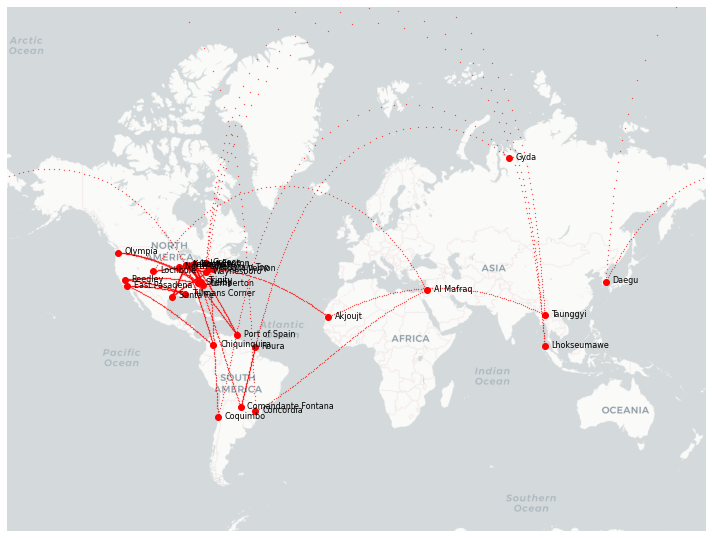

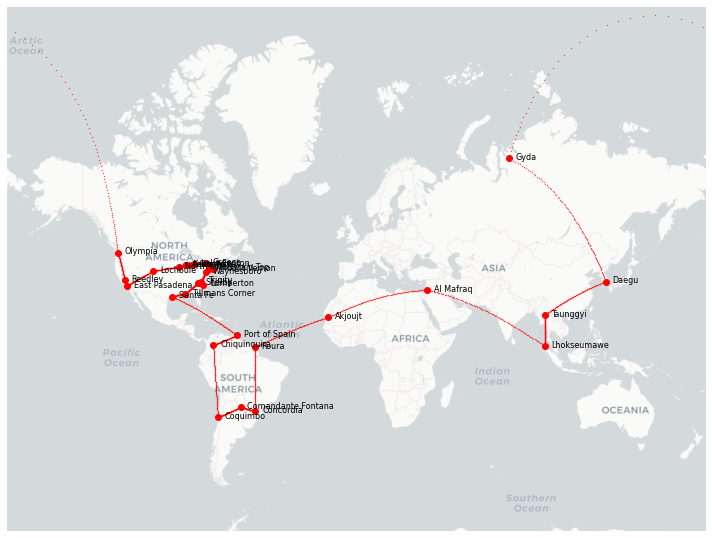

In [7]:
fig, ax = random_solution.print_route(random_solution.initial_route)
fig2, ax2 = random_solution.print_route(random_solution.best_route)

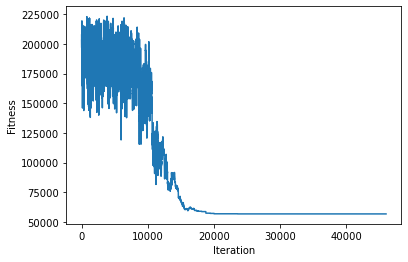

In [8]:
fig3, ax3=plt.subplots()
ax3.plot([i for i in range(len(random_solution.fitness_list))], random_solution.fitness_list)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Fitness')
plt.show()

In [9]:
random_solution.fitness(random_solution.initial_route)

202946.86043973378

In [10]:
random_solution=SalesmanAnneal(path_lats, path_lons, path_names, worldmap,  T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1)

In [11]:
max_indices = np.argsort(pop)
max_cities = city[max_indices[:25]]
max_lats = lat[max_indices[:25]]
max_lons = lon[max_indices[:25]]



In [12]:
max_soln = SalesmanAnneal(max_lats, max_lons, max_cities, worldmap,stopping_iter=-1)
max_soln.anneal()

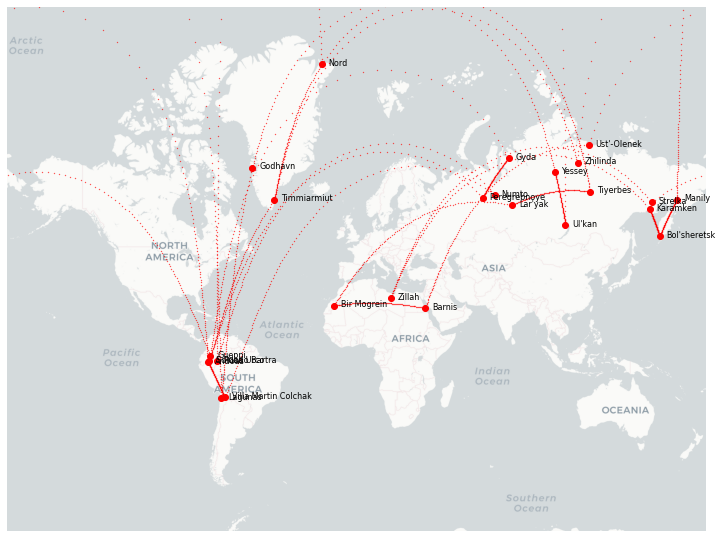

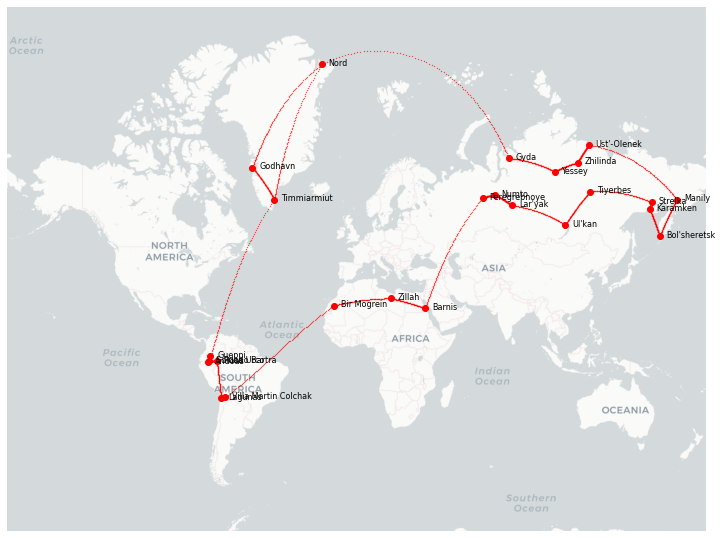

In [13]:
fig4, ax4 = max_soln.print_route(max_soln.initial_route)
fig5, ax5 = max_soln.print_route(max_soln.best_route)

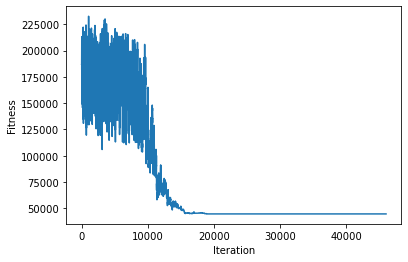

In [14]:
fig6, ax6=plt.subplots()
ax6.plot([i for i in range(len(max_soln.fitness_list))], max_soln.fitness_list)
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Fitness')
plt.show()

In [15]:
irish_indices = np.where(country == 'IRL')

irish_cities = city[irish_indices]
irish_lats = lat[irish_indices]
irish_lons = lon[irish_indices]
points=irish_lats,irish_lons

In [16]:
irish_soln = SalesmanAnneal(irish_lats, irish_lons, irish_cities, Irelandmap,stopping_iter=-1)
irish_soln.anneal()
print(len(irish_soln.solution_history))

23734


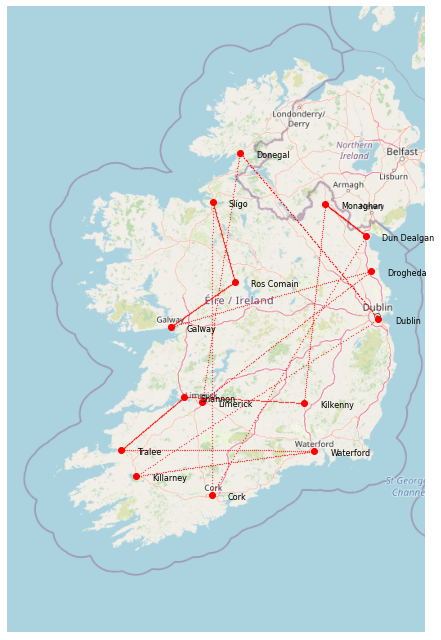

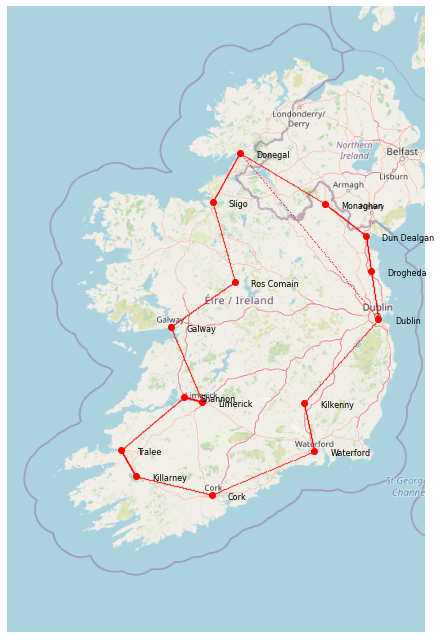

In [17]:
fig7, ax7 = irish_soln.print_route(irish_soln.initial_route)
fig8, ax8 = irish_soln.print_route(irish_soln.best_route)

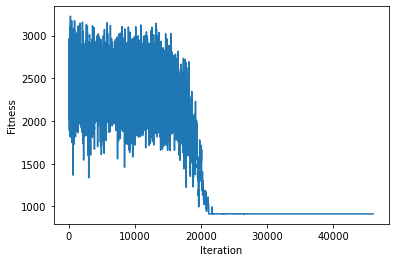

In [18]:
fig9, ax9=plt.subplots()
ax9.plot([i for i in range(len(irish_soln.fitness_list))], irish_soln.fitness_list)
ax9.set_xlabel('Iteration')
ax9.set_ylabel('Fitness')
plt.show()

In [19]:
irish_indices = np.where(country == 'IRL')

irish_cities = city[irish_indices]
irish_lats = lat[irish_indices]
irish_lons = lon[irish_indices]
points=irish_lats,irish_lons

In [20]:
irish_soln = SalesmanAnneal(irish_lats, irish_lons, irish_cities, Irelandmap,stopping_iter=-1)
irish_soln.anneal()


<IPython.core.display.Javascript object>


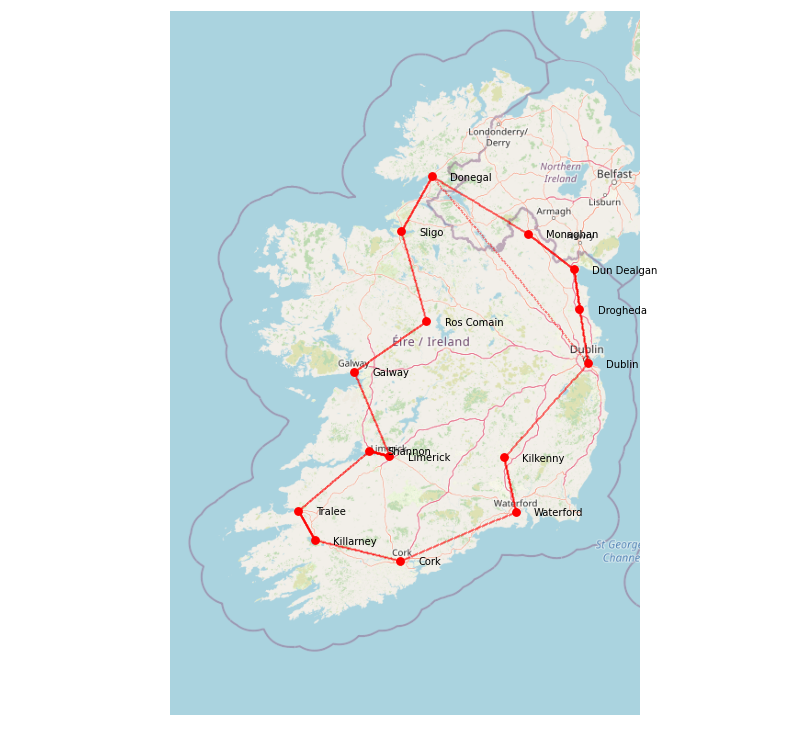

In [28]:
%matplotlib notebook
frame_division = len(irish_soln.solution_history) // 50


    
fig, ax = plt.subplots(figsize=(10, 9))
ax = plt.subplot(111)
ax.imshow(Irelandmap.img)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_xlim(0, Irelandmap.w)
ax.set_ylim(Irelandmap.h, 0)
ax.axis('off')
plt.tight_layout()
#ax.imshow(dublinmap.img)

px, py= irish_soln.basemap.to_pixels(irish_soln.lats, irish_soln.lons)
ax.plot(px, py, 'or')

[ax.annotate(irish_soln.cities[i], xy=(px[i], py[i]),xytext=(px[i]+20, py[i]+5), color='k', size=8) 
 for i in irish_soln.initial_route]   


line, = ax.plot([1], [3], 'or', ms=0.3)

def init():
    px, py= irish_soln.basemap.to_pixels(irish_soln.lats, irish_soln.lons)
    ax.plot(px, py, 'or')
    
    #include labels
    [ax.annotate(irish_soln.cities[i], xy=(px[i], py[i]), 
                    xytext=(px[i]+20, py[i]+5), color='k', size=8) 
     for i in irish_soln.initial_route]

def update(frame):
    ax.clear()
    px, py= irish_soln.basemap.to_pixels(irish_soln.lats, irish_soln.lons)
        
    #include labels
    [ax.annotate(irish_soln.cities[i], xy=(px[i], py[i]), 
                    xytext=(px[i]+20, py[i]+5), color='k', size=8) 
     for i in irish_soln.initial_route]
    ppl=100
    px1, py1 =[], []
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xlim(0, Irelandmap.w)
    ax.set_ylim(Irelandmap.h, 0)
    ax.axis('off')
    ax.imshow(Irelandmap.img)
    for i in range(0,irish_soln.N):
        leg_lat, leg_lon = irish_soln.gcd_path(irish_soln.solution_history[frame][i-1],irish_soln.solution_history[frame][i],ppl)
        px_temp, py_temp = irish_soln.basemap.to_pixels(leg_lat, leg_lon)
        px1.extend(px_temp)
        py1.extend(py_temp)    
    leg_lat, leg_lon = irish_soln.gcd_path(irish_soln.N-1,0,ppl)
    px_temp, py_temp = irish_soln.basemap.to_pixels(leg_lat, leg_lon)
    px1.extend(px_temp)
    py1.extend(py_temp)  
    ax.plot(px, py, 'or')
    ax.plot(px1, py1, 'or', ms=0.3)
    line.set_xdata(px1)
    line.set_ydata(py1)
    
    return line

irish_animation = FuncAnimation(fig, update, frames=range(0,len(irish_soln.solution_history),frame_division), 
                                repeat=False)

plt.show()
#import numpy as np
#import matplotlib
#matplotlib.use("Agg")
#import matplotlib.pyplot as plt
#import matplotlib.animation as animation



# Fixing random state for reproducibility
#np.random.seed(19680801)


# Set up formatting for the movie files
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)




#irish_animation.save('animation2.mp4', writer=writer)